# Broad IBD Challenge Luigi prototyping

## Unpack scRNA data

In [ ]:
import os, json
import spatialdata as sd 
import scanpy as sc
import numpy as np
from log1p_normalization_scale_factor import log1p_normalization_scale_factor

name_data='UC9_I'
zarr_path = f"data/{name_data}.zarr"
sdata = sd.read_zarr(zarr_path)
genes460 = sdata['anucleus'].var['gene_symbols'].values.tolist()
scRNAseq = sc.read_h5ad('data/Crunch3_scRNAseq.h5ad')

genes18615 = list(scRNAseq.var.index)
genes458 = [x for x in genes460 if x in genes18615]
genes18157 = [gene for gene in genes18615 if gene not in genes458]

# scRNA-Seq data log1p-normalized with scale factor 10000 on 18615 genes
rna_data_norm_10000_unmeasured_genes = scRNAseq[:, genes18157].X.toarray()
# scRNA-Seq data log1p-normalized with scale factor 100 on 460 genes
rna_data_norm_100_common_genes = log1p_normalization_scale_factor(scRNAseq[:, genes458].layers["counts"].toarray(), scale_factor=100)

os.makedirs('resources/run', exist_ok=True)
rundir = 'resources/run'
with open(f'{rundir}/genes458.json', 'w') as f:
    json.dump(genes458, f)
with open(f'{rundir}/genes460.json', 'w') as f:
    json.dump(genes460, f)
with open(f'{rundir}/genes18615.json', 'w') as f:
    json.dump(genes18615, f)
with open(f'{rundir}/genes18157.json', 'w') as f:
    json.dump(genes18157, f)

np.savez_compressed(f'{rundir}/scRNA_18157_gene_expressions', my_array=rna_data_norm_10000_unmeasured_genes)

np.savez_compressed(f'{rundir}/scRNA_458_gene_expressions', my_array=rna_data_norm_100_common_genes)

## Unpack UC9_I Unpack Patches and Genes

In [ ]:
target_patch_size=32
vis_width=1000
dir_dataset='resources/run'
dir_processed_dataset = 'resources/run'
dir_dataset = os.path.join(dir_dataset, "chips")
os.makedirs(dir_dataset, exist_ok=True)
name_data = 'UC9_I'
zarr_path = f"data/{name_data}.zarr"

import spatialdata as sd  # Manage multi-modal spatial omics datasets
sdata = sd.read_zarr(zarr_path)

import os
rows_to_keep = list(sdata['anucleus'].obs.sample(n=len(sdata['anucleus'].obs)).index)
# Extract spatial positions for 'train' cells
cell_id_train = sdata['anucleus'].obs["cell_id"].values
h5_path = os.path.join(dir_dataset, name_data + '_patches.h5')

from extract_spatial_positions import extract_spatial_positions
new_spatial_coord_fn = f'{dir_dataset}/{name_data}_spatial_positions.npy'
new_spatial_coord = extract_spatial_positions(sdata, cell_id_train)

import numpy as np
np.save(new_spatial_coord_fn, new_spatial_coord)
sdata['anucleus'].obsm['spatial'] = new_spatial_coord

# Create the gene expression dataset (Y)
y_subtracted = sdata['anucleus'][rows_to_keep].copy()
# Trick to set all index to same length to avoid problems when saving to h5
y_subtracted.obs.index = ['x' + str(i).zfill(6) for i in y_subtracted.obs.index]
# Check
for index in y_subtracted.obs.index:
    if len(index) != len(y_subtracted.obs.index[0]):
        warnings.warn("indices of y_subtracted.obs should all have the same length to avoid problems when saving to h5", UserWarning)

# Save the gene expression data to an H5AD file
y_subtracted.write(os.path.join(dir_dataset, f'{name_data}_genes.h5ad'))

# Extract spatial coordinates and barcodes (cell IDs) for the patches
coords_center = y_subtracted.obsm['spatial']
barcodes = np.array(y_subtracted.obs.index)

# Load the image and transpose it to the correct format
intensity_image = np.transpose(sdata['HE_original'].to_numpy(), (1, 2, 0))

# Create the patcher object to extract patches (localized square sub-region of an image) from an image at specified coordinates.
from Patcher import Patcher
patcher = Patcher(
    image=intensity_image,
    coords=coords_center,
    patch_size_target=target_patch_size
)

# Build and Save patches to an HDF5 file
patcher.to_h5(h5_path, extra_assets={'barcode': barcodes})

# Visualization
print("Extracted Images (high time and memory consumption...)")
path1 = os.path.join(dir_dataset, name_data + '_patch_locations_on_image.png')
patcher.save_visualization(path1, vis_width=vis_width)

print("Spatial coordinates")
path2 = os.path.join(dir_dataset, name_data + '_spatial_coordinates.png')
patcher.view_coord_points(path2, vis_width=vis_width)

from read_assets_from_h5 import read_assets_from_h5
# Display some example images from the created dataset
print("Examples from the created .h5 dataset")
assets, _ = read_assets_from_h5(h5_path)

import matplotlib.pylab as plt
n_images = 3
dpi = 150
fig, axes = plt.subplots(1, n_images, figsize=(15, 5))
for i in range(n_images):
    axes[i].imshow(assets["img"][i])
for ax in axes:
    ax.axis('off')
path3 = os.path.join(dir_dataset, name_data + '_patch_examples.png')
plt.savefig(path3, dpi=dpi, bbox_inches='tight')
plt.show()

## UC9_I Patches to Features

In [ ]:
encoder = "resnet50"
weights_root = "resources/pytorch_model.bin"

from inf_encoder_factory import inf_encoder_factory
encoder = inf_encoder_factory(encoder)(weights_root)

patches_path = 'resources/run/UC9_I_patches.h5'
embed_path = 'resources/run/UC9_I_features.h5'
batch_size = 128
num_workers = 0
overwrite = True

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate the embeddings and save them to the defined path
from generate_embeddings import generate_embeddings
generate_embeddings(embed_path, encoder, device, patches_path, batch_size, num_workers, overwrite=overwrite)

## UC9_I Features to PCs

In [ ]:
from read_assets_from_h5 import read_assets_from_h5
import joblib
import matplotlib.pyplot as plt
from pca_analysis import pca_analysis
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

assets, _ = read_assets_from_h5('resources/run/UC9_I_features.h5')
features = assets['embeddings']
index = assets['barcodes']
plt.hist(features.flatten(), bins=100, density=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("Chip Resnet50 Feature density")
plt.savefig('resources/run/UC9_I_feature_density.png', dpi=150, bbox_inches='tight')
B, scaler, L, V, MSE, pca_mean = pca_analysis(features[::32])
joblib.dump(scaler, 'resources/run/UC9_I_feature_PCs_scaler.joblib')
np.savez_compressed(f'resources/run/UC9_I_feature_pca_mean.npz', pca_mean)
np.savez_compressed('resources/run/UC9_I_pca_basis_explained_variance.npz', V)
np.savez_compressed('resources/run/UC9_I_pca_basis_MSE.npz', MSE)
mse_goal = 0.16
finish = np.where((MSE <=mse_goal))[-1][0]
plt.plot(MSE)
plt.xlim([finish-20, finish+20])
plt.ylim([0.12,0.20])
plt.scatter([finish],[mse_goal],color='red', s=40)
plt.title(f'Use {finish} PCs for goal of reconstruction MSE <= 0.16')
plt.savefig('resources/run/UC9_I_features_PCA_MSE.png', dpi=150, bbox_inches='tight')
basis = B[:, :finish]
X_scaled = scaler.fit_transform(features)
X_centered = X_scaled - pca_mean
PCs = X_centered @ basis
np.savez_compressed(f'resources/run/UC9_I_feature_PCs.npz', PCs)

## UC9_I Genes 460 to Genes 458

In [77]:
!ls {expr_path}

resources/run/UC9_I_genes.h5ad


In [ ]:
from load_adata import load_adata
import json
with open('resources/run/genes458.json', 'r') as f:
    genes458 = json.load(f)
barcodes = np.load('resources/run/UC9_I_barcodes.npy',allow_pickle=True)
adata = load_adata('resources/run/UC9_I_genes.h5ad', genes=genes458, barcodes=barcodes, normalize=False)

In [99]:
adata.to_csv('resources/run/UC9_I_genes458.csv.gz', compression='gzip')

## UC9_I Genes 458 to PCs

In [110]:
class foo:
    pass
self = foo()
self.object_type = 'genes458'

In [ ]:
        data = np.load('resources/run/UC9_I_genes458.npz', allow_pickle=True)['arr_0']

Text(0.5, 1.0, 'Non-0 genes458 density')

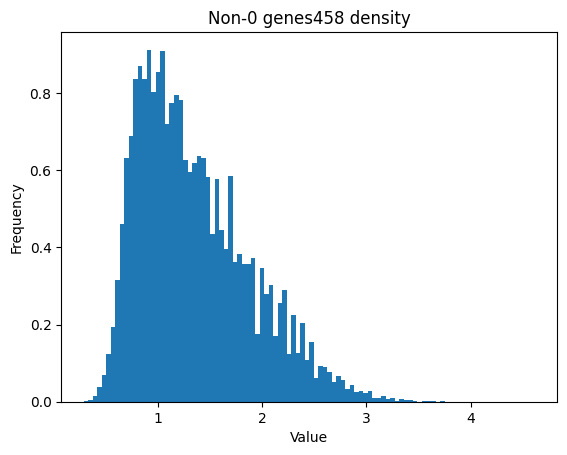

In [120]:
        foo = data.flatten()
        bar = data[data != 0]
        plt.hist(bar, bins=100, density=True)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f"Non-0 {self.object_type} density")

In [121]:
        # Create a generator for reproducibility
        rng = np.random.default_rng()
        # For a 2D array `arr` with shape (N, M)
        sampled_rows = rng.choice(data.shape[0], size=10000, replace=False)  # Indices
        sample = data[sampled_rows]  # Subset rows

In [122]:
sample

array([[1.7129786, 0.       , 2.311635 , ..., 0.       , 0.       ,
        0.       ],
       [1.1856236, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.5359092, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.0245043, 0.       , ..., 0.       , 0.       ,
        1.0245043],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [123]:
        B, scaler, L, V, MSE, pca_mean = pca_analysis(sample)

100%|████████████████████████████████████████| 458/458 [00:25<00:00, 17.75it/s]


(0.06, 0.07)

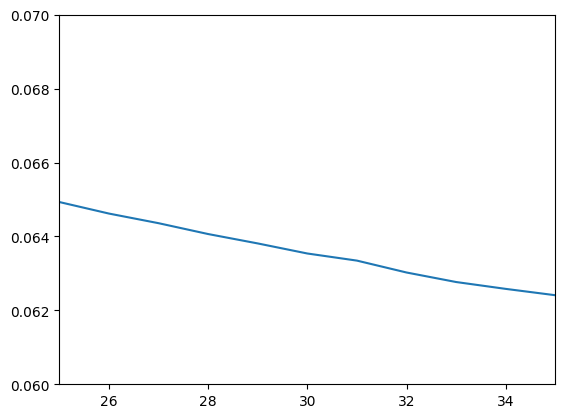

In [139]:
plt.plot(MSE)
plt.xlim(25, 35)
plt.ylim(0.06,0.07)

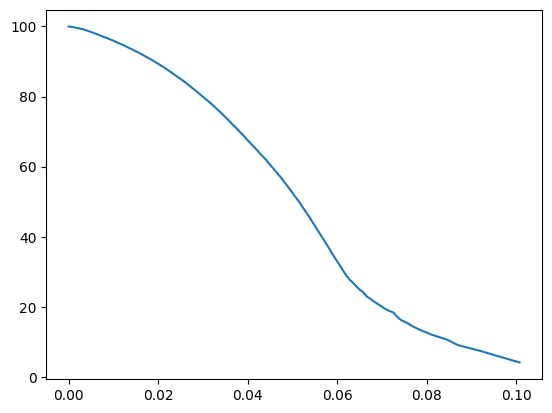

In [136]:
plt.plot(MSE, V)

In [142]:
mse_goal = 0.064
finish = np.where((MSE <=mse_goal))[-1][0]
finish

29

Text(0.5, 1.0, 'Use 29 PCs for genes458 reconstruction MSE <= 0.064')

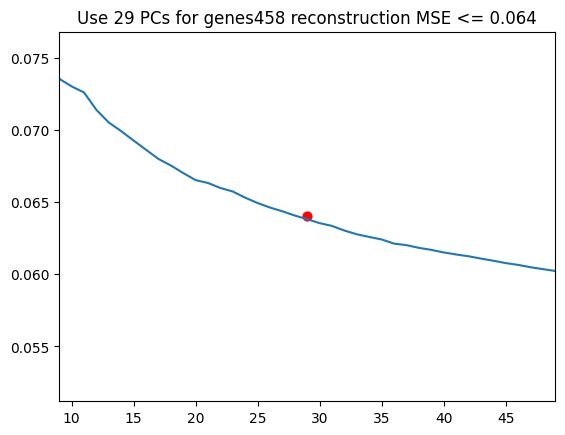

In [143]:
plt.plot(MSE)
plt.xlim([finish-20, finish+20])
plt.ylim([mse_goal * 0.8, mse_goal * 1.2])
plt.scatter([finish],[mse_goal],color='red', s=40)
plt.title(f'Use {finish} PCs for {self.object_type} reconstruction MSE <= {mse_goal}')

In [144]:
        basis = B[:, :finish]
        X_scaled = scaler.fit_transform(data)
        X_centered = X_scaled - pca_mean
        PCs = X_centered @ basis
        

## UC9_I Regress Feature PCs to Gene PCs

## Bioinformatics Plots

In [ ]:
%matplotlib inline

In [ ]:
from generate_bioinformatics_plots import generate_bioinformatics_plots

In [ ]:
X_train_fn, X_test_fn, y_train_fn, y_test_fn =[
'./resources/ST_pred_results/split0/X_train.npy', 
'./resources/ST_pred_results/split0/X_test.npy', 
'./resources/ST_pred_results/split0/y_train.npy', 
'./resources/ST_pred_results/split0/y_test.npy']

In [ ]:
import numpy as np

In [ ]:
X_train = np.load(X_train_fn).astype(np.float32)
X_test = np.load(X_test_fn).astype(np.float32)
Y_train = np.load(y_train_fn).astype(np.float32)
Y_test = np.load(y_test_fn).astype(np.float32)

In [ ]:
X_test.shape, X_train.shape

In [ ]:
Y_test.shape, Y_train.shape

In [ ]:
import json
with open('resources/processed_dataset/var_genes.json', 'r') as f:
    genes = json.load(f)

In [ ]:
genes = genes['genes']

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(Y_train, columns = genes)

In [ ]:
df.sort_values(by=list(df.columns), inplace=True)
df

In [ ]:
df1 = df[0:20]

In [ ]:
df2 = df1[df1.columns[-20:]]

In [ ]:
generate_bioinformatics_plots(df2)

## Analyze histology patch

In [ ]:
%matplotlib inline

In [ ]:
from analyze_histology_patches import analyze_histology_patches

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
X_train.shape

In [ ]:
indices = np.random.permutation(len(X_train))[:10000]  # No array copy

In [ ]:
X = X_train[indices]  

In [ ]:
X = Y_train[indices]  

In [ ]:
X_train.shape, X.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA


# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from analyze_histology_patches import analyze_histology_patches

results = analyze_histology_patches(X_scaled)
print(f"Optimal clusters: {results['optimal_k']}")
print(f"Silhouette scores: {results['silhouette_scores']}")
# Save plots
for name, fig in results['plots'].items():
    display(fig)
    fig.savefig(f"{name}.png")
    plt.close(fig)

## Try some other stuff

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)
plt.scatter(reduced[:,0], reduced[:,1])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np

def cluster_stability(X, n_clusters=2, n_iter=10):
    agreements = []
    for _ in range(n_iter):
        km1 = KMeans(n_clusters=n_clusters).fit(X)
        km2 = KMeans(n_clusters=n_clusters).fit(X)
        agreements.append(adjusted_rand_score(km1.labels_, km2.labels_))
    return np.mean(agreements)

print(f"Stability Score: {cluster_stability(X_scaled, n_clusters=7)}")  # Should be >0.8


In [ ]:
search = [(n,cluster_stability(X_scaled, n_clusters=n)) for n in range(1,15)]
search

In [ ]:
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from sklearn.metrics import davies_bouldin_score

def evaluate_k(X, k):
    km = KMeans(n_clusters=k).fit(X)
    return {
        'stability': cluster_stability(X, k),
        'silhouette': silhouette_score(X, km.labels_),
        'davies_bouldin': davies_bouldin_score(X, km.labels_)
    }

metrics = [(k, evaluate_k(X_scaled, k)) for k in tqdm(range(2,15))]

metrics

In [ ]:
# Replace PCA with UMAP for non-linear reduction
import umap
reducer = umap.UMAP(n_components=15)
X_umap = reducer.fit_transform(X_scaled)
metrics = [(k, evaluate_k(X_umap, k)) for k in tqdm(range(2,15))]
metrics

In [ ]:
kmeans = KMeans(n_clusters=4, n_init=50).fit(X_umap)

In [ ]:
from scipy.stats import kruskal
for gene in range(X_scaled.shape[1]):
    _, p = kruskal(*[X_scaled[kmeans.labels_==i, gene] for i in range(4)])
    if p < 0.001: print(f"Gene {gene} significant (p={p:.2e})")

In [ ]:
from sklearn.cluster import AgglomerativeClustering
models = [
    KMeans(n_clusters=4),
    AgglomerativeClustering(n_clusters=4)
]
consensus = np.mean([m.fit_predict(X_umap) for m in models], axis=0)


In [ ]:
# Find indices where both algorithms agree
strong_agreement_indices = np.where(np.isin(consensus, [0, 1, 2, 3]))[0]
print(f"Number of points with strong agreement: {len(strong_agreement_indices)}")
# Find indices where algorithms disagree
disagreement_indices = np.where(np.isin(consensus, [0.5]))[0]
print(f"Number of points with disagreement: {len(disagreement_indices)}")
import matplotlib.pyplot as plt
import umap
import numpy as np

# Ensure X_umap is defined
if 'X_umap' not in locals():
    # Assuming X_scaled is your data
    reducer = umap.UMAP(n_components=2)
    X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=consensus, cmap='viridis', s=50)
plt.colorbar(label='Consensus Value')
plt.title('UMAP Visualization with Consensus Clustering')
plt.show()


## And again

In [ ]:
import numpy as np
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import time

# Assuming X is your standardized 10000 x 460 matrix
X = X_scaled

# Split data into training and test sets
X_train, X_test, _, _ = train_test_split(X, X, test_size=0.2)

n_components = 15  # Number of components for most methods

methods = {
    "PCA": PCA(n_components=8),
    "UMAP": umap.UMAP(n_components=4),
}

results = {}

for name, method in methods.items():
    print(f"Processing {name}...")
    start_time = time.time()
    
    try:
        # Fit and transform the training data
        X_reduced_train = method.fit_transform(X_train)
        
        # Transform the test data
        if name == "t-SNE":
            # t-SNE doesn't have a transform method for new data
            X_reduced_test = TSNE(n_components=tsne_components, method='exact', 
                                 random_state=42, n_iter=250).fit_transform(X_test)
        else:
            X_reduced_test = method.transform(X_test)
        
        end_time = time.time()
        
        # Reconstruct the data (approximate inverse transform)
        if name == "UMAP":
            # UMAP doesn't have a direct inverse transform, so use Nearest Neighbors
            nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
            nn.fit(X_reduced_train)  # Train on reduced training data
            distances, indices = nn.kneighbors(X_reduced_test)
            # Find the original high-dimensional points corresponding to the reduced points
            X_reconstructed = X_train[indices.flatten()].reshape(X_test.shape)
        elif name == "t-SNE":
            # t-SNE doesn't have an inverse transform
            X_reconstructed = X_test
        else:
            X_reconstructed = method.inverse_transform(X_reduced_test)
        
        # Calculate MSE
        mse = mean_squared_error(X_test, X_reconstructed)
        
        results[name] = {
            "MSE": mse,
            "Time": end_time - start_time
        }
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        results[name] = {
            "MSE": float('nan'),
            "Time": float('nan')
        }

# Print Results
for name, result in results.items():
    print(f"Method: {name}")
    print(f"  MSE: {result['MSE']:.4f}")
    print(f"  Time: {result['Time']:.4f} seconds")

# Filter out methods with NaN MSE for plotting
valid_results = {k: v for k, v in results.items() if not np.isnan(v["MSE"])}

if valid_results:
    # Bar plot for MSE
    names = list(valid_results.keys())
    mse_values = [result['MSE'] for result in valid_results.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(names, mse_values, color='skyblue')
    plt.xlabel('Method')
    plt.ylabel('MSE')
    plt.title('MSE Comparison for Different Dimensionality Reduction Methods')
    plt.ylim(0, max(mse_values) * 1.1)  # Adjust y-axis limit
    plt.show()

    # Bar plot for time
    time_values = [result['Time'] for result in valid_results.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(names, time_values, color='lightgreen')
    plt.xlabel('Method')
    plt.ylabel('Time (seconds)')
    plt.title('Time Comparison for Different Dimensionality Reduction Methods')
    plt.ylim(0, max(time_values) * 1.1)  # Adjust y-axis limit
    plt.show()
else:
    print("No valid results to plot.")


In [ ]:
from visualize_pca_clusters import visualize_pca_clusters

In [ ]:
# Example usage:
# Assuming X_scaled is your standardized 10000 x 460 matrix
visualize_pca_clusters(X_scaled, n_components=3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap  # Import UMAP

def visualize_clusters(X, n_components, method='pca'):
    """
    Applies either PCA or UMAP for initial dimension reduction, then KMeans clustering,
    and visualizes the results using UMAP for 2D projection.

    Args:
        X (np.ndarray): Standardized data matrix (samples x features).
        n_components (int): Number of components and clusters to use.
        method (str): 'pca' or 'umap', specifying the dimension reduction method.
    """
    if method == 'pca':
        # Apply PCA
        reducer = PCA(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    elif method == 'umap':
        # Apply UMAP for initial dimension reduction
        reducer = umap.UMAP(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    else:
        raise ValueError("Method must be 'pca' or 'umap'")

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_components, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)

    # Visualize using UMAP for 2D projection
    reducer_umap = umap.UMAP(n_components=2)
    X_umap = reducer_umap.fit_transform(X_reduced)

    # Create a scatter plot of the reduced data, colored by cluster labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', s=5)
    plt.title(f'{method.upper()}-Reduced Data with KMeans Clusters (k={n_components})')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')

    # Add a legend
    legend1 = plt.legend(*scatter.legend_elements(),
                         loc="upper right", title="Clusters")
    plt.gca().add_artist(legend1)

    plt.show()

# Example usage:
# Assuming X_scaled is your standardized 10000 x 460 matrix
visualize_clusters(X_scaled, n_components=8, method='pca')
visualize_clusters(X_scaled, n_components=8, method='umap')


In [ ]:
visualize_clusters(X_scaled, n_components=4, method='pca')
visualize_clusters(X_scaled, n_components=4, method='umap')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap  # Import UMAP

def visualize_clusters(X, n_components, method='pca'):
    """
    Applies either PCA or UMAP for initial dimension reduction, then KMeans clustering,
    and visualizes the results using UMAP for 2D projection.

    Args:
        X (np.ndarray): Standardized data matrix (samples x features).
        n_components (int): Number of components and clusters to use.
        method (str): 'pca' or 'umap', specifying the dimension reduction method.
    """
    if method == 'pca':
        # Apply PCA
        reducer = PCA(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    elif method == 'umap':
        # Apply UMAP for initial dimension reduction
        reducer = umap.UMAP(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    else:
        raise ValueError("Method must be 'pca' or 'umap'")

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_components, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)

    # Visualize using UMAP for 2D projection
    reducer_umap = umap.UMAP(n_components=2)
    X_umap = reducer_umap.fit_transform(X_reduced)

    # Create a scatter plot of the reduced data, colored by cluster labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', s=5)
    plt.title(f'{method.upper()}-Reduced Data with KMeans Clusters (k={n_components})')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')

    # Add a legend
    legend1 = plt.legend(*scatter.legend_elements(),
                         loc="upper right", title="Clusters")
    plt.gca().add_artist(legend1)

    plt.show()

# Example usage:
# Assuming X_scaled is your standardized 10000 x 460 matrix
visualize_clusters(X_scaled, n_components=4, method='pca')
visualize_clusters(X_scaled, n_components=4, method='umap')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap  # Import UMAP
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import GaussianRandomProjection

def visualize_clusters(X, n_components, method='pca'):
    """
    Applies either PCA or UMAP for initial dimension reduction, then KMeans clustering,
    and visualizes the results using UMAP for 2D projection.

    Args:
        X (np.ndarray): Standardized data matrix (samples x features).
        n_components (int): Number of components to use.
        method (str): 'pca' or 'umap', specifying the dimension reduction method.
    """
    
    # Dimension Reduction Step
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    elif method == 'random_projection':
        reducer = GaussianRandomProjection(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    else:
        raise ValueError("Method must be 'pca', 'umap', or 'random_projection'")

    # Clustering Step (KMeans)
    kmeans = KMeans(n_clusters=n_components, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)
    
    # Visualization Step (UMAP)
    reducer_umap = umap.UMAP(n_components=2)
    X_umap = reducer_umap.fit_transform(X_reduced)

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', s=5)
    plt.title(f'{method.upper()}-Reduced Data with KMeans Clusters (k={n_components})')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.colorbar(label='Cluster')  # Add colorbar for better interpretation

    # Add a legend
    legend1 = plt.legend(*scatter.legend_elements(),
                         loc="upper right", title="Clusters")
    plt.gca().add_artist(legend1)

    plt.show()


# Example usage:
# Assuming X_scaled is your standardized 10000 x 460 matrix
X = X_scaled

In [ ]:
# You can now test each visualization method, and pick different numbers of principle components (10)
n_components=5
visualize_clusters(X, n_components=n_components, method='pca')
visualize_clusters(X, n_components=n_components, method='umap')
visualize_clusters(X, n_components=n_components, method='random_projection')

## PCA k=6 for 460 gene data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap  # Import UMAP
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

def evaluate_clustering(X, n_components, method='pca'):
    """
    Applies either PCA or UMAP for initial dimension reduction, then KMeans clustering,
    and calculates Silhouette Score and Davies-Bouldin Index.

    Args:
        X (np.ndarray): Standardized data matrix (samples x features).
        n_components (int): Number of components to use.
        method (str): 'pca' or 'umap', specifying the dimension reduction method.

    Returns:
        dict: A dictionary containing Silhouette Score and Davies-Bouldin Index.
    """
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    else:
        raise ValueError("Method must be 'pca' or 'umap'")

    # Clustering with KMeans
    kmeans = KMeans(n_clusters=n_components, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)

    # Evaluate clustering
    silhouette = silhouette_score(X_reduced, cluster_labels)
    db_index = davies_bouldin_score(X_reduced, cluster_labels)

    return {'Silhouette Score': silhouette, 'Davies-Bouldin Index': db_index, 'cluster_labels': cluster_labels, 'X_reduced': X_reduced}

In [ ]:
def visualize_clusters(X, n_components, method='pca'):
    """
    Visualizes clusters after applying either PCA or UMAP for initial dimension reduction,
    then KMeans clustering. Adds centroid labels.

    Args:
        X (np.ndarray): Standardized data matrix (samples x features).
        n_components (int): Number of components to use.
        method (str): 'pca' or 'umap', specifying the dimension reduction method.
    """
    # Evaluate clustering to get cluster labels and reduced data
    eval_results = evaluate_clustering(X, n_components, method)
    cluster_labels = eval_results['cluster_labels']
    X_reduced = eval_results['X_reduced']
    
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    else:
        raise ValueError("Method must be 'pca' or 'umap'")

    # Clustering with KMeans
    kmeans = KMeans(n_clusters=n_components, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)

    # Visualize using UMAP for 2D projection
    reducer_umap = umap.UMAP(n_components=2)
    X_umap = reducer_umap.fit_transform(X_reduced)

    # Calculate centroids
    centroids = []
    for i in range(n_components):
        centroids.append(np.mean(X_umap[cluster_labels == i], axis=0))
    centroids = np.array(centroids)

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', s=5)
    plt.title(f'{method.upper()}-Reduced Data with KMeans Clusters (k={n_components})')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.colorbar(label='Cluster')  # Add colorbar for better interpretation
    
    # Add centroid labels
    for i, centroid in enumerate(centroids):
        plt.text(centroid[0], centroid[1], str(i + 1), color='magenta', fontsize=16, ha='center', va='center', weight='bold')
        
    # Add a legend
    legend1 = plt.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
    plt.gca().add_artist(legend1)

    plt.show()

In [ ]:
# Example usage:
# Assuming X_scaled is your standardized 10000 x 460 matrix
X = X_scaled

# Evaluate different methods and number of components
results = {}
for method in ['pca', 'umap']:
    results[method] = {}
    for n_components in range(2, 11):  # Test from 2 to 10 components
        metrics = evaluate_clustering(X, n_components, method=method)
        results[method][n_components] = metrics
        print(f"Method: {method}, Components: {n_components}, Silhouette Score: {metrics['Silhouette Score']:.4f}, Davies-Bouldin Index: {metrics['Davies-Bouldin Index']:.4f}")

# Visualize the best result based on Silhouette Score (you can change this to Davies-Bouldin Index)
best_method = max(results, key=lambda m: max(results[m], key=lambda k: results[m][k]['Silhouette Score']))
best_n_components = max(results[best_method], key=lambda k: results[best_method][k]['Silhouette Score'])

print(f"Best Method: {best_method}, Best Components: {best_n_components}")
visualize_clusters(X, n_components=best_n_components, method=best_method)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap  # Import UMAP
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

def evaluate_clustering(X, n_components, method='pca'):
    """
    Applies either PCA or UMAP for initial dimension reduction, then KMeans clustering,
    and calculates Silhouette Score and Davies-Bouldin Index.

    Args:
        X (np.ndarray): Standardized data matrix (samples x features).
        n_components (int): Number of components to use.
        method (str): 'pca' or 'umap', specifying the dimension reduction method.

    Returns:
        dict: A dictionary containing Silhouette Score and Davies-Bouldin Index.
    """
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    else:
        raise ValueError("Method must be 'pca' or 'umap'")

    # Clustering with KMeans
    kmeans = KMeans(n_clusters=n_components, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)

    # Evaluate clustering
    silhouette = silhouette_score(X_reduced, cluster_labels)
    db_index = davies_bouldin_score(X_reduced, cluster_labels)

    return {'Silhouette Score': silhouette, 'Davies-Bouldin Index': db_index, 'cluster_labels': cluster_labels, 'X_reduced': X_reduced}

def visualize_clusters(X, n_components, method='pca', ax=None):
    """
    Visualizes clusters after applying either PCA or UMAP for initial dimension reduction,
    then KMeans clustering. Adds centroid labels.

    Args:
        X (np.ndarray): Standardized data matrix (samples x features).
        n_components (int): Number of components to use.
        method (str): 'pca' or 'umap', specifying the dimension reduction method.
        ax (matplotlib.axes._axes.Axes, optional): The axes object to draw the plot onto. If None, creates a new figure and axes.
    """
    # Evaluate clustering to get cluster labels and reduced data
    eval_results = evaluate_clustering(X, n_components, method)
    cluster_labels = eval_results['cluster_labels']
    X_reduced = eval_results['X_reduced']
    silhouette = eval_results['Silhouette Score']
    db_index = eval_results['Davies-Bouldin Index']
    
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components)
        X_reduced = reducer.fit_transform(X)
    else:
        raise ValueError("Method must be 'pca' or 'umap'")

    # Clustering with KMeans
    kmeans = KMeans(n_clusters=n_components, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)

    # Visualize using UMAP for 2D projection
    reducer_umap = umap.UMAP(n_components=2)
    X_umap = reducer_umap.fit_transform(X_reduced)

    # Calculate centroids
    centroids = []
    for i in range(n_components):
        centroids.append(np.mean(X_umap[cluster_labels == i], axis=0))
    centroids = np.array(centroids)

    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', s=5)
    ax.set_title(f'{method.upper()} (k={n_components})\nSilhouette={silhouette:.2f}, DBIndex={db_index:.2f}')
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    
    # Add centroid labels
    for i, centroid in enumerate(centroids):
        ax.text(centroid[0], centroid[1], str(i), color=plt.cm.viridis(i/n_components), fontsize=12, ha='center', va='center')

    # Add a legend
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
    ax.add_artist(legend1)

In [ ]:
# Example usage:
# Assuming X_scaled is your standardized 10000 x 460 matrix
X = X_scaled

# Define the range of n_components to test
n_components_range = range(4, 9)  # From 4 to 8

# Create a figure with subplots for each n_components
fig, axes = plt.subplots(len(n_components_range), 2, figsize=(20, 8 * len(n_components_range)))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop over each n_components and visualize PCA and UMAP side by side
for i, n_components in enumerate(n_components_range):
    visualize_clusters(X, n_components=n_components, method='pca', ax=axes[2*i])
    visualize_clusters(X, n_components=n_components, method='umap', ax=axes[2*i + 1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# Example usage:
# Assuming X_scaled is your standardized 10000 x 460 matrix
X = X_scaled

# Define the range of n_components to test
n_components_range = range(4, 9)  # From 4 to 8

# Loop over each n_components and visualize PCA and UMAP separately
for n_components in n_components_range:
    print(f"Plotting for n_components = {n_components}...")
    visualize_clusters(X, n_components=n_components, method='pca')
    visualize_clusters(X, n_components=n_components, method='umap')

## PCA final decision for patch 1024 feature vectors

In [ ]:
X.shape

X_scaled = scaler.fit_transform(X)

X_scaled.shape

X = X_scaled[0:1000]

# Define the range of n_components to test
n_components_range = range(2,9)

# Loop over each n_components and visualize PCA and UMAP separately
for n_components in n_components_range:
    print(f"Plotting for n_components = {n_components}...")
    visualize_clusters(X, n_components=n_components, method='pca')
    # visualize_clusters(X, n_components=n_components, method='umap')


## Ridge Regress PCA of genes from PCA of feature vectors and measure MSE and Spearman rank correlation at that level, save fit as F

## Project from PCA of genes to genes and measure MSE and Spearman rank correlation at that level

## PCA of 18157 genes less the 460 genes

In [ ]:
import scanpy as sc
scRNAseq = sc.read_h5ad('data/Crunch3_scRNAseq.h5ad')

filter_value_no_cancer = "n" # Filtered column value indicating absence of cancer
filter_value_cancer = "y" # Filtered column value indicating the presence of cancer
filter_column_scRNAseq = "dysplasia"

# Filter scRNAseq data by dysplasia status
scRNAseq_no_cancer = scRNAseq[scRNAseq.obs[filter_column_scRNAseq] == filter_value_no_cancer].copy()
scRNAseq_cancer = scRNAseq[scRNAseq.obs[filter_column_scRNAseq] == filter_value_cancer].copy()

scRNAseq_no_cancer

name_data = 'UC9_I'

# Get the 18615 genes to rank
gene_18615_list = list(scRNAseq.var.index)

gene_460 = genes

In [ ]:
common_genes = [g for g in gene_460 if g in gene_18615_list]
print("Number of shared genes between scRNA-seq and xenium data:", len(common_genes))

In [ ]:
unmeasured_genes = [gene for gene in gene_18615_list if gene not in common_genes]
print("Number of unmeasured genes in Xenium data:", len(unmeasured_genes), "\n")

In [ ]:
# scRNA-Seq data log1p-normalized with scale factor 10000 on 18615 genes
rna_data_norm_10000_unmeasured_genes = scRNAseq[:, unmeasured_genes].X.toarray()

from log1p_normalization_scale_factor import log1p_normalization_scale_factor

# scRNA-Seq data log1p-normalized with scale factor 100 on 460 genes
rna_data_norm_100_common_genes = log1p_normalization_scale_factor(scRNAseq[:, common_genes].layers["counts"].toarray(), scale_factor=100)

In [ ]:
rna_data_norm_100_common_genes.shape

In [ ]:
print(f"Xenium data shape ({len(prediction_460_genes)} samples x {len(common_genes)} shared genes)")

In [ ]:
# Similarity-Based Matching: Find the top_k most similar spots for each query
top_k = 30
print(f"\nCompute COSINE SIMILARITY: Find the top_k(={top_k}) similar scRNA-Seq cells for each Xenium cell...\n")
matches, similarities = find_matches_cos_similarity(rna_data_norm_100_common_genes, prediction_460_genes[common_genes].values, top_k=top_k)
del rna_data_norm_100_common_genes

# Weighted Averaging of scRNA-Seq data log1p-normalized with scale factor 10000
print("Compute WEIGHTED AVERAGE of unmeasured genes from scRNA-Seq based on similarity scores...")
weighted_avg_df_10000 = pd.DataFrame([
    {
        **dict(zip(unmeasured_genes, np.average(rna_data_norm_10000_unmeasured_genes[indices, :], axis=0, weights=similarity).round(2)))  # updated
    }
    for i, (indices, similarity) in enumerate(zip(matches, similarities))
])
weighted_avg_df_10000.index = prediction_460_genes.index

# Free memory by deleting large variables and performing garbage collection
del rna_data_norm_10000_unmeasured_genes, matches, similarities

prediction_18615_genes = pd.concat([prediction_460_genes, weighted_avg_df_10000], axis=1)[gene_18615_list]

print(f"\n-- {name_data} PREDICTION DONE --\n")